In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Load P&L data from CSV
pnl_df = pd.read_csv("pnl_over_time.csv")
pnl_df['datetime'] = pd.to_datetime(pnl_df['datetime'])

print(f"Loaded {len(pnl_df)} trades")
print(f"Date range: {pnl_df['datetime'].min()} to {pnl_df['datetime'].max()}")
print(f"Final P&L: ${pnl_df['pnl'].iloc[-1]:,.2f} ({pnl_df['pnl_pct'].iloc[-1]:.2f}%)")
print(f"\nFirst few trades:")
pnl_df.head()

Loaded 323 trades
Date range: 2014-02-13 11:02:00+00:00 to 2024-12-18 14:07:00+00:00
Final P&L: $-46,011.97 (-46.01%)

First few trades:


,datetime,symbol,side,quantity,price,cash,position_voo,position_sh,total_equity,pnl,pnl_pct
0,2014-02-13 11:02:00+00:00,VOO,BUY,599,167.142205,-118.180731,599,0,100000.000000,0.000000,0.000000
1,2014-03-14 09:30:00+00:00,VOO,SELL,599,169.520000,101424.299269,0,0,101424.299269,1424.299269,1.424299
2,2014-03-24 10:27:00+00:00,SH,BUY,2366,198.960005,-369315.072203,0,2366,101424.299269,1424.299269,1.424299
3,2014-04-02 15:29:00+00:00,SH,SELL,2366,195.519995,93285.236086,0,0,93285.236086,-6714.763914,-6.714764
4,2014-04-04 09:30:00+00:00,VOO,BUY,539,173.810000,-398.353914,539,0,93285.236086,-6714.763914,-6.714764


In [138]:
# Load 1-minute VOO data
# First check what CSV files we have
import os
data_files = [f for f in os.listdir("raw_data") if "VOO" in f and ".csv" in f]
print("Available VOO data files:")
for f in data_files:
    print(f"  - {f}")

# Load 1-minute data
minute_file = "./raw_data/VOO_1min_splits_only_standard.csv"
if os.path.exists(minute_file):
    df_minute = pd.read_csv(minute_file)
    df_minute['timestamp'] = pd.to_datetime(df_minute['timestamp'])
    df_minute = df_minute.sort_values('timestamp')
    print(f"\nLoaded {len(df_minute)} minute bars")
    print(f"Date range: {df_minute['timestamp'].min()} to {df_minute['timestamp'].max()}")
    df_minute.head()
else:
    print(f"File {minute_file} not found")

Available VOO data files:
  - VOO_1min_splits_only_standard.csv
  - VOO_daily_splits_only.csv

Loaded 1148835 minute bars
Date range: 2013-01-02 09:30:00 to 2024-12-31 15:59:00


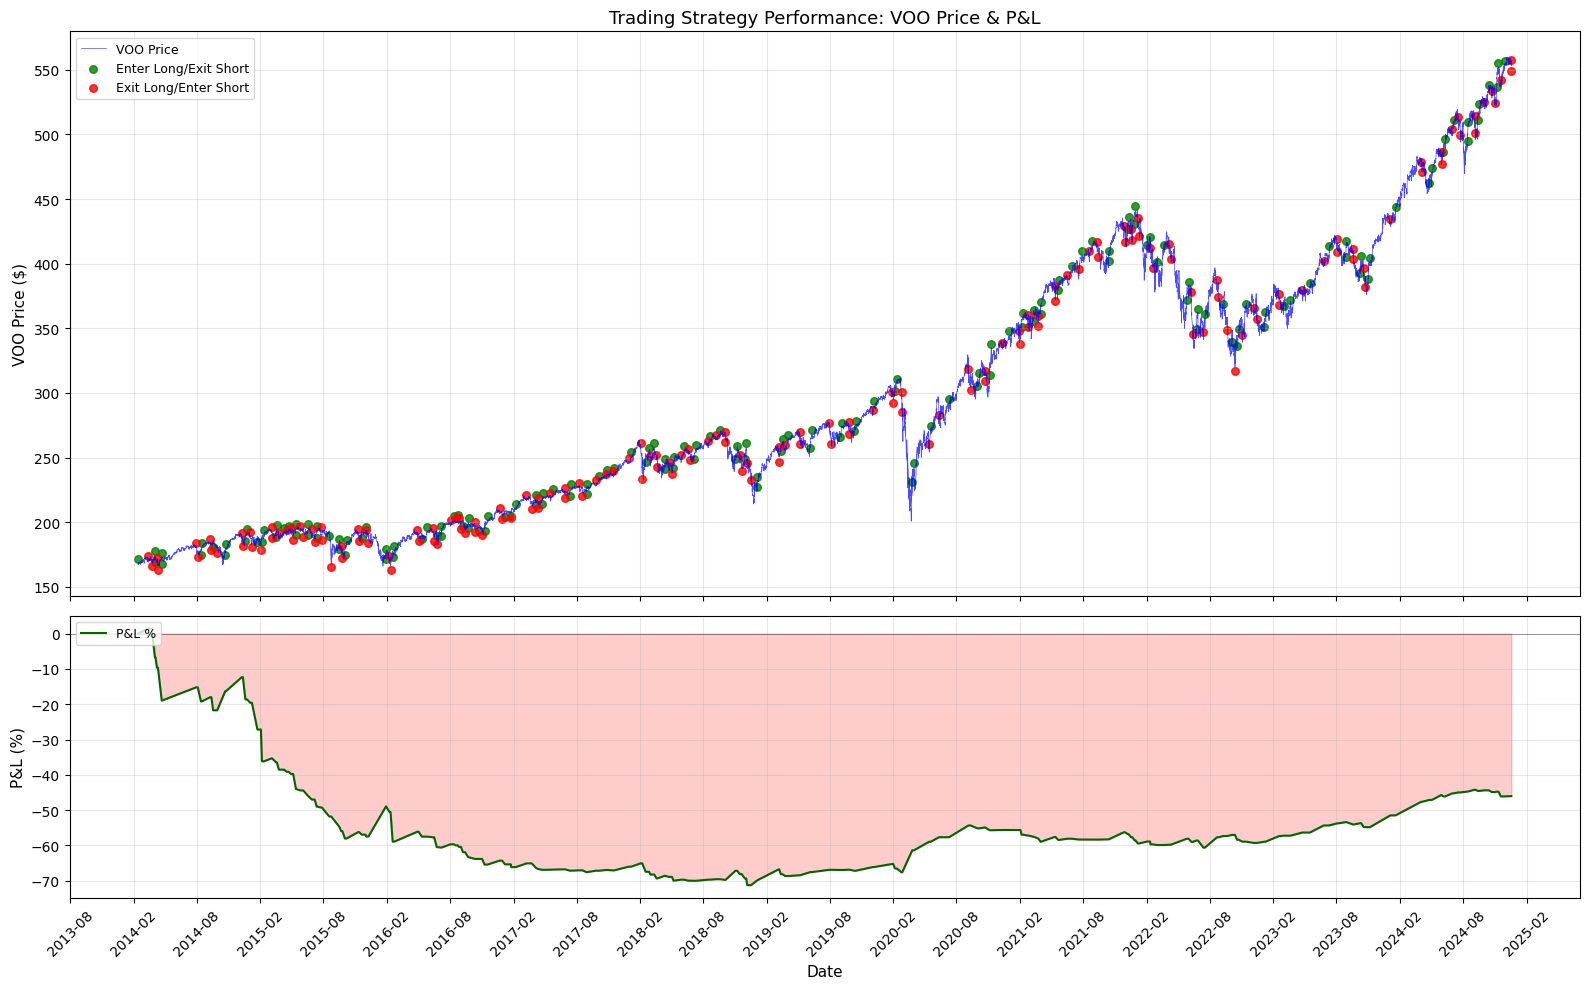


=== Strategy Performance Summary ===
Date range: 2014-02-13 to 2024-12-18
Total trades: 323
  Enter Long: 91
  Exit Long: 91
  Enter Short: 71
  Exit Short: 70

Final P&L: $-46,011.97 (-46.01%)
Max P&L: $1,424.30 (1.42%)
Min P&L: $-71,233.85 (-71.23%)


In [139]:
# Visualization with VOO price and P&L curve
# First, categorize the trades from P&L data
trades_categorized = []
for _, trade in pnl_df.iterrows():
    if trade['symbol'] == 'VOO':
        if trade['side'] == 'BUY':
            action = 'EnterLong'
        else:
            action = 'ExitLong'
    else:  # SH
        if trade['side'] == 'BUY':
            action = 'EnterShort'
        else:
            action = 'ExitShort'
    
    trades_categorized.append({
        'timestamp': trade['datetime'],
        'action': action,
        'price': trade['price']
    })

df_pos = pd.DataFrame(trades_categorized)

# Remove timezone info to match df_minute (or add timezone to df_minute)
df_pos['timestamp'] = pd.to_datetime(df_pos['timestamp']).dt.tz_localize(None)
pnl_df['datetime'] = pd.to_datetime(pnl_df['datetime']).dt.tz_localize(None)

# Filter df_minute to start from first trade
first_trade_time = df_pos['timestamp'].min()
last_trade_time = df_pos['timestamp'].max()
df_minute_filtered = df_minute[(df_minute['timestamp'] >= first_trade_time) & 
                               (df_minute['timestamp'] <= last_trade_time)].copy()

# Get VOO price at each trade timestamp
def get_voo_price_at_time(trade_time):
    time_diffs = abs(df_minute_filtered['timestamp'] - trade_time)
    if len(time_diffs) > 0:
        closest_idx = time_diffs.idxmin()
        return df_minute_filtered.loc[closest_idx, 'close']
    return None

df_pos['voo_price'] = df_pos['timestamp'].apply(get_voo_price_at_time)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), 
                                gridspec_kw={'height_ratios': [2, 1]},
                                sharex=True)

# Top subplot: VOO price with trade signals
ax1.plot(df_minute_filtered['timestamp'], df_minute_filtered['close'], 
         color='blue', linewidth=0.5, alpha=0.7, label='VOO Price')

# Plot trade signals as dots with fixed offsets from VOO price
enter_long_df = df_pos[df_pos['action'] == 'EnterLong']
exit_short_df = df_pos[df_pos['action'] == 'ExitShort']
exit_long_df = df_pos[df_pos['action'] == 'ExitLong']
enter_short_df = df_pos[df_pos['action'] == 'EnterShort']

# Green dots (Enter Long / Exit Short)
if not enter_long_df.empty:
    ax1.scatter(enter_long_df['timestamp'], enter_long_df['voo_price'] + 4, 
               color='green', s=30, marker='o', alpha=0.8, label='Enter Long/Exit Short')
if not exit_short_df.empty:
    ax1.scatter(exit_short_df['timestamp'], exit_short_df['voo_price'] - 4, 
               color='green', s=30, marker='o', alpha=0.8)

# Red dots (Exit Long / Enter Short)  
if not exit_long_df.empty:
    ax1.scatter(exit_long_df['timestamp'], exit_long_df['voo_price'] + 4, 
               color='red', s=30, marker='o', alpha=0.8, label='Exit Long/Enter Short')
if not enter_short_df.empty:
    ax1.scatter(enter_short_df['timestamp'], enter_short_df['voo_price'] - 4, 
               color='red', s=30, marker='o', alpha=0.8)

ax1.set_ylabel('VOO Price ($)', fontsize=11)
ax1.set_title('Trading Strategy Performance: VOO Price & P&L', fontsize=13)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', fontsize=9)

# Bottom subplot: P&L curve
ax2.plot(pnl_df['datetime'], pnl_df['pnl_pct'], 
         color='darkgreen', linewidth=1.5, label='P&L %')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax2.fill_between(pnl_df['datetime'], 0, pnl_df['pnl_pct'], 
                  where=(pnl_df['pnl_pct'] >= 0), color='green', alpha=0.2)
ax2.fill_between(pnl_df['datetime'], 0, pnl_df['pnl_pct'], 
                  where=(pnl_df['pnl_pct'] < 0), color='red', alpha=0.2)

ax2.set_ylabel('P&L (%)', fontsize=11)
ax2.set_xlabel('Date', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left', fontsize=9)

# Format x-axis
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print summary
print(f"\n=== Strategy Performance Summary ===")
print(f"Date range: {first_trade_time.date()} to {last_trade_time.date()}")
print(f"Total trades: {len(df_pos)}")
print(f"  Enter Long: {len(enter_long_df)}")
print(f"  Exit Long: {len(exit_long_df)}")
print(f"  Enter Short: {len(enter_short_df)}")
print(f"  Exit Short: {len(exit_short_df)}")
print(f"\nFinal P&L: ${pnl_df['pnl'].iloc[-1]:,.2f} ({pnl_df['pnl_pct'].iloc[-1]:.2f}%)")
print(f"Max P&L: ${pnl_df['pnl'].max():,.2f} ({pnl_df['pnl_pct'].max():.2f}%)")
print(f"Min P&L: ${pnl_df['pnl'].min():,.2f} ({pnl_df['pnl_pct'].min():.2f}%)")